## References: 
+ https://www.pybloggers.com/2018/10/repeated-measures-anova-in-python-using-statsmodels/
+ https://pingouin-stats.org/

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.stats.anova import AnovaRM
import pingouin as pg

### Preliminaries

In [3]:
## Grab sample data. 
# Replace this with LDM data (should have the same format)
behav_path = '/Users/angelaradulescu/Dropbox/research/thesis/data/3_ACAL-2/AllData.csv' 
behav_data = pd.read_csv(behav_path)
subjects = behav_data['Subj'].unique()

## Get metadata.
n_trials = max(behav_data['Trial'])
n_games = max(behav_data['Game'])
game_length = len(behav_data.loc[(behav_data['Subj'] == 1) & (behav_data['Game'] == 1)])

## Add trial-within-game variable.
behav_data['Trial_2'] = behav_data['Trial'] - (behav_data['Game']-1)*game_length
behav_data.head(5)

,Subj,Trial,Game,Stim11,Stim12,Stim13,Stim21,Stim22,Stim23,Stim31,...,Outcome,Dim,Feat,CenterDim,CenterFeat,Correct,LearnedFeat,PoL,RT,Trial_2
0,1,1,1,2,4,9,1,5,7,3,...,1.0,2,5,1,1,0,9.0,20,1.97010,1
1,1,2,1,2,5,9,3,6,8,1,...,NaN,2,5,1,3,0,9.0,20,NaN,2
2,1,3,1,2,5,7,1,4,9,3,...,0.0,2,5,1,1,1,9.0,20,0.57229,3
3,1,4,1,3,5,9,2,6,7,1,...,1.0,2,5,1,2,1,9.0,20,0.76743,4
4,1,5,1,2,5,9,1,6,8,3,...,1.0,2,5,1,1,1,9.0,20,0.71366,5


### 1. Visualize RT

For illustration, we look at how trial within game (**Trial_2**) and dimension (**Dim**) affect **RT**.

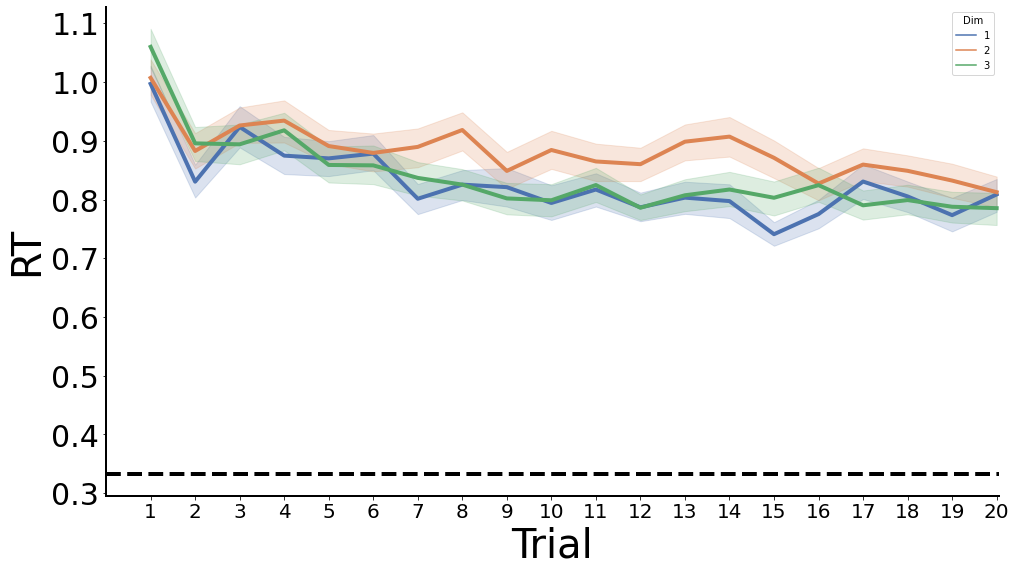

In [84]:
# This line groups by relevant variables (aka factors). 
df = pd.melt(behav_data, col_level=0, id_vars=['Subj','Trial_2','Dim'], value_vars=['RT']).dropna()

fig, ax = plt.subplots(figsize=(16,9))
ax.axhline(y=1/3, color='k', lw=4, linestyle='--');
sns.lineplot(x = "Trial_2", y="value", hue='Dim', err_style="band", ci=68, data=df, lw=4, palette='deep')
sns.despine()
ax.set_xlim([0,game_length+.05])
# ax.set_ylim([0.3,0.8])
ax.set_xticks(np.arange(game_length)+1)
xl = ax.set_xlabel('Trial',fontsize = 40);
yl = ax.set_ylabel('RT',fontsize = 40);
for axis in ['top','bottom','left','right']:
      ax.spines[axis].set_linewidth(2)
ax.tick_params(axis='x',colors='k')
plt.xticks(fontsize=20);
plt.yticks(fontsize=30);

Based on the above plot, we would expect a significant effect of both dimension and trial (RT is generally higher for Dimension 2 and decreases over time). 

### 2. Reformat data for 2-way repeated-measures ANOVA

We're first going to run a 2-way repeated measures ANOVA in which both factors of interest are *within-subject*. The "melt" command above also reformatted the data to the way that the ANOVA function expects it. 
Let's have a look:

In [85]:
df.head(10)

,Subj,Trial_2,Dim,variable,value
0,1,1,2,RT,1.97010
2,1,3,2,RT,0.57229
3,1,4,2,RT,0.76743
4,1,5,2,RT,0.71366
5,1,6,2,RT,0.63904
6,1,7,2,RT,1.13090
7,1,8,2,RT,1.04870
8,1,9,2,RT,0.63695
9,1,10,2,RT,0.86444
10,1,11,2,RT,1.02920


The dependent variable is **RT**, and it's coded in the **value** column. The factors we are interested in are **Trial_2** (within-subject) and **Dim** (also within-subject). The **Subj** column is considered the "random effect." We can run a repeated-measures ANOVA using the *statsmethods* package like so: 

In [86]:
print(AnovaRM(data=df, depvar='value', subject='Subj', within=['Trial_2', 'Dim'], aggregate_func='mean').fit())

                   Anova
            F Value  Num DF  Den DF  Pr > F
-------------------------------------------
Trial_2      7.6795 19.0000 380.0000 0.0000
Dim         13.1048  2.0000  40.0000 0.0000
Trial_2:Dim  1.0208 38.0000 760.0000 0.4369



As expected, both the main effects (**Trial_2** and **Dim**) are significant. Their interaction is not significant (that is, the effect of dimension doesn't depend on trial number.)

### 3. Run mixed 2-way ANOVA.

For LDM, we need a mixed ANOVA in which one of the factors (**Age**) is between-subjects. Just for illustration, let's add a fake between-subjects age column to our dataframe. 

In [88]:
df['Age'] = 'adolescents'
df.loc[df['Subj'] < 10,'Age'] = 'adults'
df.head(10)

,Subj,Trial_2,Dim,variable,value,Age
0,1,1,2,RT,1.97010,adults
2,1,3,2,RT,0.57229,adults
3,1,4,2,RT,0.76743,adults
4,1,5,2,RT,0.71366,adults
5,1,6,2,RT,0.63904,adults
6,1,7,2,RT,1.13090,adults
7,1,8,2,RT,1.04870,adults
8,1,9,2,RT,0.63695,adults
9,1,10,2,RT,0.86444,adults
10,1,11,2,RT,1.02920,adults


Then we can run the model using the *pingouin* package: 

In [89]:
aov = pg.mixed_anova(data=df, dv='value', between='Age', within='Trial_2',
                     subject='Subj', correction=False, effsize="np2")
pg.print_table(aov)


ANOVA SUMMARY

Source          SS    DF1    DF2     MS      F    p-unc    np2      eps
-----------  -----  -----  -----  -----  -----  -------  -----  -------
Age          0.134      1     19  0.134  0.297    0.592  0.015  nan
Trial_2      1.097     19    361  0.058  7.605    0.000  0.286    0.302
Interaction  0.080     19    361  0.004  0.557    0.934  0.028  nan



As expected, the p-value for Age is non-significant (since we added it at random), while **Trial_2** remains significant.

This section can now be adapted for the entropy computation :)